In [94]:
from keras.callbacks import ModelCheckpoint
from keras import backend as K
from keras import optimizers
from keras.layers import Dense
from keras.layers import Dense, Dropout
from keras.models import Sequential
from keras.wrappers.scikit_learn import KerasClassifier
from pandas import ExcelFile
from pandas import ExcelWriter
from PIL import Image
from scipy import ndimage
from scipy.stats import randint as sp_randint
from sklearn.base import BaseEstimator
from sklearn.base import TransformerMixin
from sklearn.ensemble import ExtraTreesClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.feature_selection import SelectFromModel
from sklearn import datasets
from sklearn import metrics
from sklearn import pipeline
from sklearn.metrics import roc_auc_score, roc_curve
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import ShuffleSplit
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.preprocessing import Imputer
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.utils import resample
from tensorflow.python.framework import ops
import h5py
import keras
import matplotlib.pyplot as plt
import numpy as np
import openpyxl
import pandas as pd
import scipy
import tensorflow as tf
import xlsxwriter
%load_ext autoreload
%matplotlib inline
import numpy as np
from keras import layers
from keras.layers import Input, Add, Dense, Activation, ZeroPadding2D, BatchNormalization, Flatten, Conv2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D
from keras.models import Model, load_model
from keras.preprocessing import image
from keras.utils import layer_utils
from keras.utils.data_utils import get_file
from keras.applications.imagenet_utils import preprocess_input
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model

from keras.initializers import glorot_uniform
import scipy.misc
from matplotlib.pyplot import imshow
%matplotlib inline

import keras.backend as K

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [95]:


from __future__ import print_function
import rdkit
from rdkit import Chem
from rdkit.Chem import AllChem
import pandas as pd
import numpy as np
 
from matplotlib import pyplot as plt
%matplotlib inline
print("RDKit: %s"%rdkit.__version__)



RDKit: 2017.09.1


In [96]:

import keras
from sklearn.utils import shuffle
from keras.models import Sequential, Model
from keras.layers import Conv2D, MaxPooling2D, Input, GlobalMaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import ReduceLROnPlateau
print("Keras: %s"%keras.__version__)



Keras: 2.2.4


In [97]:
data = pd.read_excel(r'IGC50.xlsx')

In [98]:


X_train_smiles = np.array(list(data["smiles"][data["split"]==1]))
X_test_smiles = np.array(list(data["smiles"][data["split"]==0]))
print(X_train_smiles.shape)
print(X_test_smiles.shape)



(1434,)
(358,)


In [99]:


assay = "Activity"  
Y_train = data[assay][data["split"]==1].values.reshape(-1,1)
Y_test = data[assay][data["split"]==0].values.reshape(-1,1)



In [100]:

charset = set("".join(list(data.smiles))+"!E")
char_to_int = dict((c,i) for i,c in enumerate(charset))
int_to_char = dict((i,c) for i,c in enumerate(charset))
embed = max([len(smile) for smile in data.smiles]) + 5
print (str(charset))
print(len(charset), embed)

{'O', '+', 'S', '/', 'C', '3', 'F', 'B', 'H', 'l', '-', '=', 'P', '1', '#', '4', 'E', 'I', '!', '\\', '(', ']', ')', 'N', '2', 'r', '['}
27 57


In [101]:
char_to_int 

{'O': 0,
 '+': 1,
 'S': 2,
 '/': 3,
 'C': 4,
 '3': 5,
 'F': 6,
 'B': 7,
 'H': 8,
 'l': 9,
 '-': 10,
 '=': 11,
 'P': 12,
 '1': 13,
 '#': 14,
 '4': 15,
 'E': 16,
 'I': 17,
 '!': 18,
 '\\': 19,
 '(': 20,
 ']': 21,
 ')': 22,
 'N': 23,
 '2': 24,
 'r': 25,
 '[': 26}

In [102]:
def vectorize(smiles):
        one_hot =  np.zeros((smiles.shape[0], embed , len(charset)),dtype=np.int8)
        for i,smile in enumerate(smiles):
            #encode the startchar
            one_hot[i,0,char_to_int["!"]] = 1
            #encode the rest of the chars
            for j,c in enumerate(smile):
                one_hot[i,j+1,char_to_int[c]] = 1
            #Encode endchar
            one_hot[i,len(smile)+1:,char_to_int["E"]] = 1
        #Return two, one for input and the other for output
        return one_hot[:,0:-1,:], one_hot[:,1:,:]

In [103]:
X_train, _ = vectorize(X_train_smiles)
X_test, _ = vectorize(X_test_smiles)

In [104]:
X_train[8].shape

(56, 27)

In [105]:
mol_str_train=[]
mol_str_test=[]
for x in range(1434):
 
    mol_str_train.append("".join([int_to_char[idx] for idx in np.argmax(X_train[x,:,:], axis=1)]))
    
    
for x in range(358):
    mol_str_test.append("".join([int_to_char[idx] for idx in np.argmax(X_test[x,:,:], axis=1)]))

In [106]:
vocab_size=len(charset)

In [107]:
from keras.preprocessing.text import one_hot
from keras.preprocessing.sequence import pad_sequences
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import Flatten
from keras.layers.embeddings import Embedding

In [118]:
model = Sequential()
model.add(Embedding(vocab_size, 100, input_length=embed-1))
model.add(keras.layers.Conv1D(192,50,activation='relu'))
model.add(keras.layers.GRU(224, return_sequences=True))
#model.add(keras.layers.LSTM(284))
model.add(keras.layers.GRU(284))
#model.add(Flatten())
model.add(Dense(100, activation='relu'))
#model.add(Dropout(0.4))
model.add(Dense(1, activation='linear'))

In [119]:
def coeff_determination(y_true, y_pred):
    from keras import backend as K
    SS_res =  K.sum(K.square( y_true-y_pred ))
    SS_tot = K.sum(K.square( y_true - K.mean(y_true) ) )
    return ( 1 - SS_res/(SS_tot + K.epsilon()) )

In [120]:


def get_lr_metric(optimizer):
    def lr(y_true, y_pred):
        return optimizer.lr
    return lr



In [121]:
mol_str_train = np.asarray(mol_str_train)
mol_str_test = np.asarray(mol_str_test)

In [122]:
optimizer = Adam(lr=0.00025)
lr_metric = get_lr_metric(optimizer)
model.compile(loss="mse", optimizer=optimizer, metrics=[coeff_determination, lr_metric])

In [123]:
callbacks_list = [
    ReduceLROnPlateau(monitor='val_loss', factor=0.5, patience=5, min_lr=1e-15, verbose=1, mode='auto',cooldown=0),
    ModelCheckpoint(filepath="weights.best.hdf5", monitor='val_loss', save_best_only=True, verbose=1, mode='auto')
    
]



history =model.fit(x=np.argmax(X_train, axis=2), y=Y_train,
                              batch_size=128,
                              epochs=300,
                              validation_data=(np.argmax(X_test, axis=2),Y_test),
                              callbacks=callbacks_list)

Train on 1434 samples, validate on 358 samples
Epoch 1/300
1434/1434 [==============================] - 1s 904us/step - loss: 8.4588 - coeff_determination: -6.4283 - lr: 2.5000e-04 - val_loss: 1.5197 - val_coeff_determination: -0.5955 - val_lr: 2.5000e-04

Epoch 00001: val_loss improved from inf to 1.51972, saving model to weights.best.hdf5
Epoch 2/300
1434/1434 [==============================] - 0s 137us/step - loss: 1.9408 - coeff_determination: -0.7222 - lr: 2.5000e-04 - val_loss: 1.6462 - val_coeff_determination: -0.7151 - val_lr: 2.5000e-04

Epoch 00002: val_loss did not improve from 1.51972
Epoch 3/300
1434/1434 [==============================] - 0s 135us/step - loss: 1.2649 - coeff_determination: -0.1105 - lr: 2.5000e-04 - val_loss: 0.9621 - val_coeff_determination: -0.0061 - val_lr: 2.5000e-04

Epoch 00003: val_loss improved from 1.51972 to 0.96209, saving model to weights.best.hdf5
Epoch 4/300
1434/1434 [==============================] - 0s 155us/step - loss: 0.9036 - coeff_de

1434/1434 [==============================] - 0s 133us/step - loss: 0.4139 - coeff_determination: 0.6313 - lr: 2.5000e-04 - val_loss: 0.4161 - val_coeff_determination: 0.5732 - val_lr: 2.5000e-04

Epoch 00029: val_loss improved from 0.42677 to 0.41610, saving model to weights.best.hdf5
Epoch 30/300
1434/1434 [==============================] - 0s 218us/step - loss: 0.4073 - coeff_determination: 0.6402 - lr: 2.5000e-04 - val_loss: 0.4388 - val_coeff_determination: 0.5485 - val_lr: 2.5000e-04

Epoch 00030: val_loss did not improve from 0.41610
Epoch 31/300
1434/1434 [==============================] - 0s 129us/step - loss: 0.3899 - coeff_determination: 0.6548 - lr: 2.5000e-04 - val_loss: 0.4302 - val_coeff_determination: 0.5599 - val_lr: 2.5000e-04

Epoch 00031: val_loss did not improve from 0.41610
Epoch 32/300
1434/1434 [==============================] - 0s 129us/step - loss: 0.3861 - coeff_determination: 0.6594 - lr: 2.5000e-04 - val_loss: 0.4520 - val_coeff_determination: 0.5342 - val_l

1434/1434 [==============================] - 0s 138us/step - loss: 0.2624 - coeff_determination: 0.7646 - lr: 1.2500e-04 - val_loss: 0.3652 - val_coeff_determination: 0.6253 - val_lr: 1.2500e-04

Epoch 00059: val_loss improved from 0.37095 to 0.36518, saving model to weights.best.hdf5
Epoch 60/300
1434/1434 [==============================] - 0s 208us/step - loss: 0.2655 - coeff_determination: 0.7632 - lr: 1.2500e-04 - val_loss: 0.3632 - val_coeff_determination: 0.6279 - val_lr: 1.2500e-04

Epoch 00060: val_loss improved from 0.36518 to 0.36315, saving model to weights.best.hdf5
Epoch 61/300
1434/1434 [==============================] - 0s 258us/step - loss: 0.2378 - coeff_determination: 0.7901 - lr: 1.2500e-04 - val_loss: 0.3936 - val_coeff_determination: 0.5929 - val_lr: 1.2500e-04

Epoch 00061: val_loss did not improve from 0.36315
Epoch 62/300
1434/1434 [==============================] - 0s 160us/step - loss: 0.2351 - coeff_determination: 0.7885 - lr: 1.2500e-04 - val_loss: 0.3612 - 


Epoch 00088: val_loss did not improve from 0.35083
Epoch 89/300
1434/1434 [==============================] - 0s 129us/step - loss: 0.1520 - coeff_determination: 0.8643 - lr: 1.5625e-05 - val_loss: 0.3699 - val_coeff_determination: 0.6168 - val_lr: 1.5625e-05

Epoch 00089: val_loss did not improve from 0.35083
Epoch 90/300
1434/1434 [==============================] - 0s 131us/step - loss: 0.1534 - coeff_determination: 0.8641 - lr: 1.5625e-05 - val_loss: 0.3560 - val_coeff_determination: 0.6333 - val_lr: 1.5625e-05

Epoch 00090: val_loss did not improve from 0.35083
Epoch 91/300
1434/1434 [==============================] - 0s 130us/step - loss: 0.1519 - coeff_determination: 0.8635 - lr: 1.5625e-05 - val_loss: 0.3570 - val_coeff_determination: 0.6322 - val_lr: 1.5625e-05

Epoch 00091: ReduceLROnPlateau reducing learning rate to 7.812500371073838e-06.

Epoch 00091: val_loss did not improve from 0.35083
Epoch 92/300
1434/1434 [==============================] - 0s 131us/step - loss: 0.1512 

1434/1434 [==============================] - 0s 133us/step - loss: 0.1465 - coeff_determination: 0.8694 - lr: 2.4414e-07 - val_loss: 0.3579 - val_coeff_determination: 0.6306 - val_lr: 2.4414e-07

Epoch 00118: val_loss did not improve from 0.35083
Epoch 119/300
1434/1434 [==============================] - 0s 132us/step - loss: 0.1465 - coeff_determination: 0.8697 - lr: 2.4414e-07 - val_loss: 0.3580 - val_coeff_determination: 0.6304 - val_lr: 2.4414e-07

Epoch 00119: val_loss did not improve from 0.35083
Epoch 120/300
1434/1434 [==============================] - 0s 130us/step - loss: 0.1465 - coeff_determination: 0.8682 - lr: 2.4414e-07 - val_loss: 0.3581 - val_coeff_determination: 0.6303 - val_lr: 2.4414e-07

Epoch 00120: val_loss did not improve from 0.35083
Epoch 121/300
1434/1434 [==============================] - 0s 128us/step - loss: 0.1465 - coeff_determination: 0.8699 - lr: 2.4414e-07 - val_loss: 0.3583 - val_coeff_determination: 0.6301 - val_lr: 2.4414e-07

Epoch 00121: ReduceLR


Epoch 00147: val_loss did not improve from 0.35083
Epoch 148/300
1434/1434 [==============================] - 0s 134us/step - loss: 0.1465 - coeff_determination: 0.8696 - lr: 3.8147e-09 - val_loss: 0.3580 - val_coeff_determination: 0.6304 - val_lr: 3.8147e-09

Epoch 00148: val_loss did not improve from 0.35083
Epoch 149/300
1434/1434 [==============================] - 0s 132us/step - loss: 0.1465 - coeff_determination: 0.8696 - lr: 3.8147e-09 - val_loss: 0.3580 - val_coeff_determination: 0.6304 - val_lr: 3.8147e-09

Epoch 00149: val_loss did not improve from 0.35083
Epoch 150/300
1434/1434 [==============================] - 0s 129us/step - loss: 0.1465 - coeff_determination: 0.8685 - lr: 3.8147e-09 - val_loss: 0.3580 - val_coeff_determination: 0.6304 - val_lr: 3.8147e-09

Epoch 00150: val_loss did not improve from 0.35083
Epoch 151/300
1434/1434 [==============================] - 0s 129us/step - loss: 0.1465 - coeff_determination: 0.8695 - lr: 3.8147e-09 - val_loss: 0.3580 - val_coeff

1434/1434 [==============================] - 0s 131us/step - loss: 0.1465 - coeff_determination: 0.8684 - lr: 5.9605e-11 - val_loss: 0.3580 - val_coeff_determination: 0.6304 - val_lr: 5.9605e-11

Epoch 00177: val_loss did not improve from 0.35083
Epoch 178/300
1434/1434 [==============================] - 0s 130us/step - loss: 0.1465 - coeff_determination: 0.8696 - lr: 5.9605e-11 - val_loss: 0.3580 - val_coeff_determination: 0.6304 - val_lr: 5.9605e-11

Epoch 00178: val_loss did not improve from 0.35083
Epoch 179/300
1434/1434 [==============================] - 0s 128us/step - loss: 0.1465 - coeff_determination: 0.8677 - lr: 5.9605e-11 - val_loss: 0.3580 - val_coeff_determination: 0.6304 - val_lr: 5.9605e-11

Epoch 00179: val_loss did not improve from 0.35083
Epoch 180/300
1434/1434 [==============================] - 0s 129us/step - loss: 0.1465 - coeff_determination: 0.8698 - lr: 5.9605e-11 - val_loss: 0.3580 - val_coeff_determination: 0.6304 - val_lr: 5.9605e-11

Epoch 00180: val_loss

1434/1434 [==============================] - 0s 131us/step - loss: 0.1465 - coeff_determination: 0.8686 - lr: 9.3132e-13 - val_loss: 0.3580 - val_coeff_determination: 0.6304 - val_lr: 9.3132e-13

Epoch 00207: val_loss did not improve from 0.35083
Epoch 208/300
1434/1434 [==============================] - 0s 129us/step - loss: 0.1465 - coeff_determination: 0.8692 - lr: 9.3132e-13 - val_loss: 0.3580 - val_coeff_determination: 0.6304 - val_lr: 9.3132e-13

Epoch 00208: val_loss did not improve from 0.35083
Epoch 209/300
1434/1434 [==============================] - 0s 130us/step - loss: 0.1465 - coeff_determination: 0.8688 - lr: 9.3132e-13 - val_loss: 0.3580 - val_coeff_determination: 0.6304 - val_lr: 9.3132e-13

Epoch 00209: val_loss did not improve from 0.35083
Epoch 210/300
1434/1434 [==============================] - 0s 129us/step - loss: 0.1465 - coeff_determination: 0.8684 - lr: 9.3132e-13 - val_loss: 0.3580 - val_coeff_determination: 0.6304 - val_lr: 9.3132e-13

Epoch 00210: val_loss

1434/1434 [==============================] - 0s 129us/step - loss: 0.1465 - coeff_determination: 0.8701 - lr: 1.4552e-14 - val_loss: 0.3580 - val_coeff_determination: 0.6304 - val_lr: 1.4552e-14

Epoch 00237: val_loss did not improve from 0.35083
Epoch 238/300
1434/1434 [==============================] - 0s 131us/step - loss: 0.1465 - coeff_determination: 0.8691 - lr: 1.4552e-14 - val_loss: 0.3580 - val_coeff_determination: 0.6304 - val_lr: 1.4552e-14

Epoch 00238: val_loss did not improve from 0.35083
Epoch 239/300
1434/1434 [==============================] - 0s 131us/step - loss: 0.1465 - coeff_determination: 0.8674 - lr: 1.4552e-14 - val_loss: 0.3580 - val_coeff_determination: 0.6304 - val_lr: 1.4552e-14

Epoch 00239: val_loss did not improve from 0.35083
Epoch 240/300
1434/1434 [==============================] - 0s 129us/step - loss: 0.1465 - coeff_determination: 0.8663 - lr: 1.4552e-14 - val_loss: 0.3580 - val_coeff_determination: 0.6304 - val_lr: 1.4552e-14

Epoch 00240: val_loss

1434/1434 [==============================] - 0s 160us/step - loss: 0.1465 - coeff_determination: 0.8684 - lr: 1.0000e-15 - val_loss: 0.3580 - val_coeff_determination: 0.6304 - val_lr: 1.0000e-15

Epoch 00267: val_loss did not improve from 0.35083
Epoch 268/300
1434/1434 [==============================] - 0s 160us/step - loss: 0.1465 - coeff_determination: 0.8689 - lr: 1.0000e-15 - val_loss: 0.3580 - val_coeff_determination: 0.6304 - val_lr: 1.0000e-15

Epoch 00268: val_loss did not improve from 0.35083
Epoch 269/300
1434/1434 [==============================] - 0s 140us/step - loss: 0.1465 - coeff_determination: 0.8680 - lr: 1.0000e-15 - val_loss: 0.3580 - val_coeff_determination: 0.6304 - val_lr: 1.0000e-15

Epoch 00269: val_loss did not improve from 0.35083
Epoch 270/300
1434/1434 [==============================] - 0s 132us/step - loss: 0.1465 - coeff_determination: 0.8692 - lr: 1.0000e-15 - val_loss: 0.3580 - val_coeff_determination: 0.6304 - val_lr: 1.0000e-15

Epoch 00270: val_loss

1434/1434 [==============================] - 0s 128us/step - loss: 0.1465 - coeff_determination: 0.8666 - lr: 1.0000e-15 - val_loss: 0.3580 - val_coeff_determination: 0.6304 - val_lr: 1.0000e-15

Epoch 00297: val_loss did not improve from 0.35083
Epoch 298/300
1434/1434 [==============================] - 0s 129us/step - loss: 0.1465 - coeff_determination: 0.8695 - lr: 1.0000e-15 - val_loss: 0.3580 - val_coeff_determination: 0.6304 - val_lr: 1.0000e-15

Epoch 00298: val_loss did not improve from 0.35083
Epoch 299/300
1434/1434 [==============================] - 0s 130us/step - loss: 0.1465 - coeff_determination: 0.8683 - lr: 1.0000e-15 - val_loss: 0.3580 - val_coeff_determination: 0.6304 - val_lr: 1.0000e-15

Epoch 00299: val_loss did not improve from 0.35083
Epoch 300/300
1434/1434 [==============================] - 0s 129us/step - loss: 0.1465 - coeff_determination: 0.8691 - lr: 1.0000e-15 - val_loss: 0.3580 - val_coeff_determination: 0.6304 - val_lr: 1.0000e-15

Epoch 00300: val_loss

/home/abdulkarim/.local/lib/python3.6/site-packages/matplotlib/cbook/deprecation.py:107: MatplotlibDeprecationWarning: Adding an axes using the same arguments as a previous axes currently reuses the earlier instance.  In a future version, a new instance will always be created and returned.  Meanwhile, this warning can be suppressed, and the future behavior ensured, by passing a unique label to each axes instance.
  warnings.warn(message, mplDeprecation, stacklevel=1)
No handles with labels found to put in legend.
No handles with labels found to put in legend.


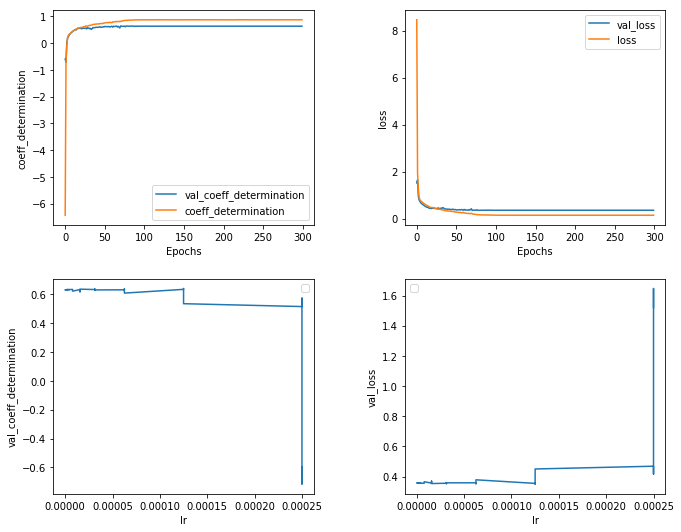

In [124]:
hist = history.history

plt.figure(figsize=(10, 8))

for label in ['val_coeff_determination','coeff_determination']:
    plt.subplot(221)
    plt.plot(hist[label], label = label)
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("coeff_determination")
    
for label in ['val_loss','loss']:
    plt.subplot(222)
    plt.plot(hist[label], label = label)
    plt.legend()
    plt.xlabel("Epochs")
    plt.ylabel("loss")



plt.subplot(223)
plt.plot( hist['lr'],hist['val_coeff_determination']  )
plt.legend()
plt.xlabel("lr")
plt.ylabel("val_coeff_determination")


plt.subplot(224)
plt.plot( hist['lr'],hist['val_loss']  )
plt.legend()
plt.xlabel("lr")
plt.ylabel("val_loss")

    
plt.subplots_adjust(top=0.92, bottom=0.08, left=0.10, right=0.95, hspace=0.25,
                    wspace=0.35)